# Ablation study for MixUp
This notebook runs an ablation study for MixUp data augmentation to measure the effect by which this feature improves the model. The training metrics here are compared against those from the Standard_for_ablation_comparison.ipynb notebook, and interpreted/summarized at the end of the notebook.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rnapark","key":"f766d3a80003b91cb04f4e4633ffd077"}'}

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets list

ref                                                             title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025                Spotify Global Music Dataset (2009–2025)               1289021  2025-11-11 09:43:05.933000           5109        104  1.0              
sadiajavedd/students-academic-performance-dataset               Students_Academic_Performance_Dataset                     8907  2025-10-23 04:16:35.563000          10847        273  1.0              
kundanbedmutha/customer-sentiment-dataset                       Customer Sentiment Dataset                              296232  2025-11-19 08:18:50.493000            995         27  1.0              


In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

plant_pathology_2020_fgvc7_path = kagglehub.competition_download('plant-pathology-2020-fgvc7')
rnapark_resnet18_f37072fd_pth_path = kagglehub.dataset_download('rnapark/resnet18-f37072fd-pth')
rnapark_resnet34_b627a593_pth_path = kagglehub.dataset_download('rnapark/resnet34-b627a593-pth')

print('Data source import complete.')


100%|██████████| 779M/779M [00:08<00:00, 93.3MB/s]

Extracting files...


100%|██████████| 41.4M/41.4M [00:00<00:00, 195MB/s]

Extracting files...


100%|██████████| 77.2M/77.2M [00:00<00:00, 213MB/s]

Extracting files...


Data source import complete.


# Load data

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image
import os

class AppleDataset(Dataset):
  def __init__(self, csv_path, images, transform=None, is_test=False):
    self.data = pd.read_csv(csv_path)
    self.images = images
    self.transform = transform
    self.is_test = is_test

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    row = self.data.iloc[idx]
    image_path = os.path.join(self.images, row['image_id']+".jpg")
    image = Image.open(image_path).convert('RGB')
    if self.transform:
      image = self.transform(image)

    if self.is_test:
      return image
    else:
      label = row[['healthy', 'multiple_diseases', 'rust', 'scab']].values.astype("float32")
      return image, label


# Input data files are available in the read-only "../input/" directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# file paths
base_dir = plant_pathology_2020_fgvc7_path
train_csv = base_dir + "/train.csv"
test_csv  = base_dir + "/test.csv"
images = base_dir + "/images"

train_data = AppleDataset(train_csv, images, transform=None)
test_data  = AppleDataset(test_csv, images, transform=None, is_test=True)

# Commented out the below because transforms are not defined until later
# train_set, val_set = random_split(train_data, [0.8, 0.2])

# # Prepare DataLoaders
# train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# print("Data loaded successfully!")
# print("Train batches:", len(train_loader))
# print("Val batches:", len(val_loader))
# print("Test batches:", len(test_loader))

# images, labels = next(iter(train_loader))
# print(images.shape)  # (64, 3, H, W)
# print(labels.shape)  # (64, 4)


## Helper to visualize training curves

In [ ]:
from matplotlib import pyplot as plt

# Helper function to visualize performance during training
def plot_training_curves(train_losses, val_accuracies):
    """Plot training loss and validation accuracy curves.

    Parameters
    ----------
    train_losses : list of float
        Training loss values for each epoch. Should have one value per epoch.
    val_accuracies : list of float
        Validation accuracy values for each epoch. Should have same length as
        train_losses. Accuracy values should be between 0 and 1 (or 0 and 100
        if using percentages).

    Returns
    -------
    None
        Displays matplotlib figure with two subplots showing training curves.

    Examples
    --------
    >>> train_losses = [0.8, 0.6, 0.4, 0.3, 0.2]
    >>> val_accuracies = [0.75, 0.80, 0.85, 0.87, 0.88]
    >>> plot_training_curves(train_losses, val_accuracies)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(val_accuracies)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Define training loop, evaluation loop

In [ ]:
# Define train/test loop

def mixup_data(x, y, alpha=0.2):
    # Returns mixed inputs, pairs of targets, and lambda
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def train_loop(
        dataloader,
        model,
        loss_fn,
        optimizer,
        device,
        smoothing=0.02,
        grad_clip=1.0,
        use_mixup=False,
        mixup_alpha=0.2
    ):

    model.train()
    total_loss = 0.0

    for X, y in dataloader:
        X = X.to(device)
        y = y.float().to(device)
        y_smooth = y * (1 - smoothing) + (1 - y) * smoothing

        # MixUp augmentation
        if use_mixup:
            X, y_a, y_b, lam = mixup_data(X, y_smooth, alpha=mixup_alpha)

            # Apply label smoothing AFTER mixup
            y_a = y_a * (1 - smoothing) + (1 - y_a) * smoothing
            y_b = y_b * (1 - smoothing) + (1 - y_b) * smoothing

            pred = model(X)
            loss = lam * loss_fn(pred, y_a) + (1 - lam) * loss_fn(pred, y_b)
        else:
            # Only smoothing if NOT using mixup
            y_smooth = y * (1 - smoothing) + (1 - y) * smoothing
            pred = model(X)
            loss = loss_fn(pred, y_smooth)

        optimizer.zero_grad()
        loss.backward()

        # gradient clipping
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)
def evaluate_model(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct_predictions_sum = 0, 0
    num_labels = 4 # Number of output labels in our dataset

    model.eval()
    with torch.no_grad():
      for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X) # These are logits
        test_loss += loss_fn(pred, y).item()

        # Apply sigmoid to logits to get probabilities
        probabilities = torch.sigmoid(pred)
        # Threshold probabilities to get binary predictions (0 or 1)
        predicted_labels = (probabilities > 0.5).float()
        # Count total correct individual label predictions (TP + TN)
        correct_predictions_sum += (predicted_labels == y).float().sum().item()

    test_loss = test_loss / num_batches
    # Calculate overall accuracy as the ratio of correctly predicted individual labels
    # to the total possible individual labels (num_samples * num_labels)
    total_possible_labels = size * num_labels
    accuracy = correct_predictions_sum / total_possible_labels
    return test_loss, accuracy

def predict_loop(loader, model, device):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)  # Raw probabilities for each class

            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())

    return torch.cat(all_labels, dim=0), torch.cat(all_probs, dim=0)

def predict_test_loop(loader, model, device):
    model.eval()
    all_probs = []

    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, (list, tuple)):
                images = batch[0]
            else:
                images = batch

            images = images.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)  # Raw probabilities

            all_probs.append(probs.cpu())

    return torch.cat(all_probs, dim=0)


# Improving model with fine tuning

In [ ]:
def apply_thresholding(probs, thresholds):
    # Apply thresholds to the predicted probabilities.

    # Initialize an array to store the predictions for each sample
    preds = torch.zeros_like(probs, dtype=torch.long)

    for i in range(probs.shape[0]):  # Iterate over each sample in the batch
        for c in range(probs.shape[1]):  # Iterate over each class
            if probs[i, c] > thresholds[c]:  # Check if the probability exceeds the threshold
                preds[i, c] = 1  # Set the class prediction to 1 (indicating the class is selected)

    # For each sample, choose the class with the maximum probability if no class exceeds threshold
    preds = torch.argmax(probs, dim=1)  # Use the highest probability class if no threshold is surpassed

    return preds

## Defining visualizations for evaluation

In [ ]:
# Confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, roc_auc_score, precision_recall_fscore_support

def plot_confusion_matrix(y_true, y_pred, class_names):
    # Generate a confusion matrix for each class in a one-vs-rest manner
    for i, class_name in enumerate(class_names):
        # For each class, consider it as positive and all others as negative
        true_labels = y_true[:, i]
        pred_labels = y_pred[:, i]
        cm = confusion_matrix(true_labels, pred_labels)

        # Extract metrics
        tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0) # Handle cases where a class might not be present
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        print(f"\nMetrics for class: {class_name}")
        print(f"  True Positives (TP): {tp}")
        print(f"  False Positives (FP): {fp}")
        print(f"  False Negatives (FN): {fn}")
        print(f"  True Negatives (TN): {tn}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")

        # Calculate and print F1-score
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        print(f"  F1-score: {f1_score:.4f}")

        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=[f'Not {class_name}', class_name],
                    yticklabels=[f'Not {class_name}', class_name])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix for {class_name}')
        plt.show()

def plot_precision_recall_curve(y_true, y_pred, class_names):
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        plt.plot(recall, precision, label=f'{class_names[i]}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

def plot_roc_curve(y_true, y_pred, class_names):
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()


Training fold 1...
Epoch 1/15 - Fold 1
Training Loss: 1.0778, Validation Loss: 0.9510, Validation Accuracy: 0.6123
Epoch 2/15 - Fold 1
Training Loss: 0.9655, Validation Loss: 0.8532, Validation Accuracy: 0.6637
Epoch 3/15 - Fold 1
Training Loss: 0.8388, Validation Loss: 0.7139, Validation Accuracy: 0.7562
Epoch 4/15 - Fold 1
Training Loss: 0.7218, Validation Loss: 0.5783, Validation Accuracy: 0.8459
Epoch 5/15 - Fold 1
Training Loss: 0.6181, Validation Loss: 0.4732, Validation Accuracy: 0.8979
Epoch 6/15 - Fold 1
Training Loss: 0.5340, Validation Loss: 0.4027, Validation Accuracy: 0.9219
Epoch 7/15 - Fold 1
Training Loss: 0.4652, Validation Loss: 0.3328, Validation Accuracy: 0.9418
Epoch 8/15 - Fold 1
Training Loss: 0.4301, Validation Loss: 0.2847, Validation Accuracy: 0.9514
Epoch 9/15 - Fold 1
Training Loss: 0.3958, Validation Loss: 0.2952, Validation Accuracy: 0.9589
Epoch 10/15 - Fold 1
Training Loss: 0.3849, Validation Loss: 0.2749, Validation Accuracy: 0.9582
Epoch 11/15 - Fold 

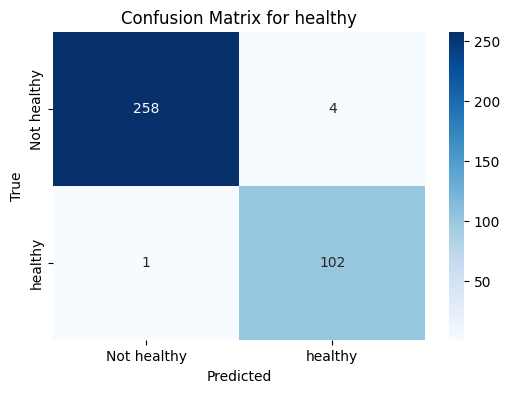


Metrics for class: multiple_diseases
  True Positives (TP): 10
  False Positives (FP): 7
  False Negatives (FN): 8
  True Negatives (TN): 340
  Precision: 0.5882
  Recall: 0.5556
  F1-score: 0.5714


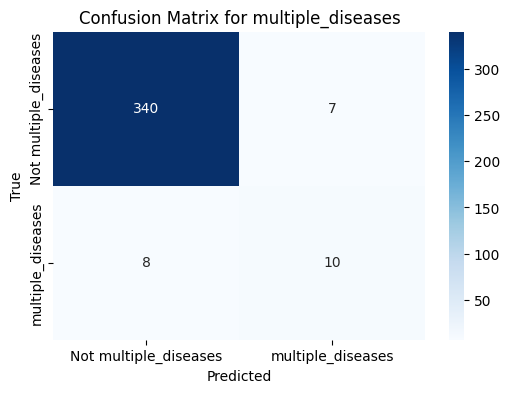


Metrics for class: rust
  True Positives (TP): 123
  False Positives (FP): 11
  False Negatives (FN): 2
  True Negatives (TN): 229
  Precision: 0.9179
  Recall: 0.9840
  F1-score: 0.9498


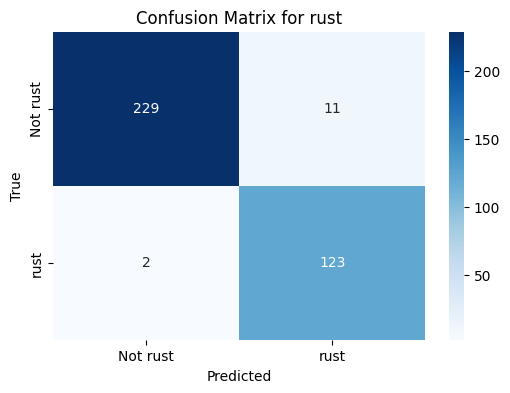


Metrics for class: scab
  True Positives (TP): 116
  False Positives (FP): 7
  False Negatives (FN): 3
  True Negatives (TN): 239
  Precision: 0.9431
  Recall: 0.9748
  F1-score: 0.9587


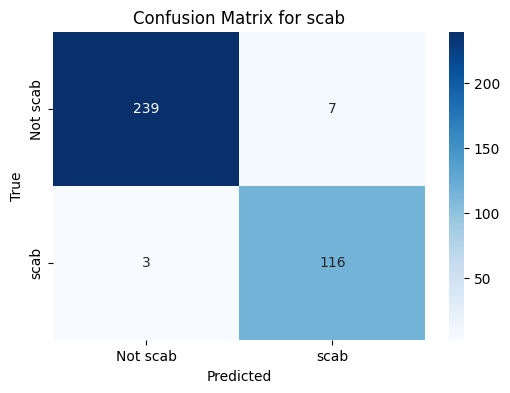

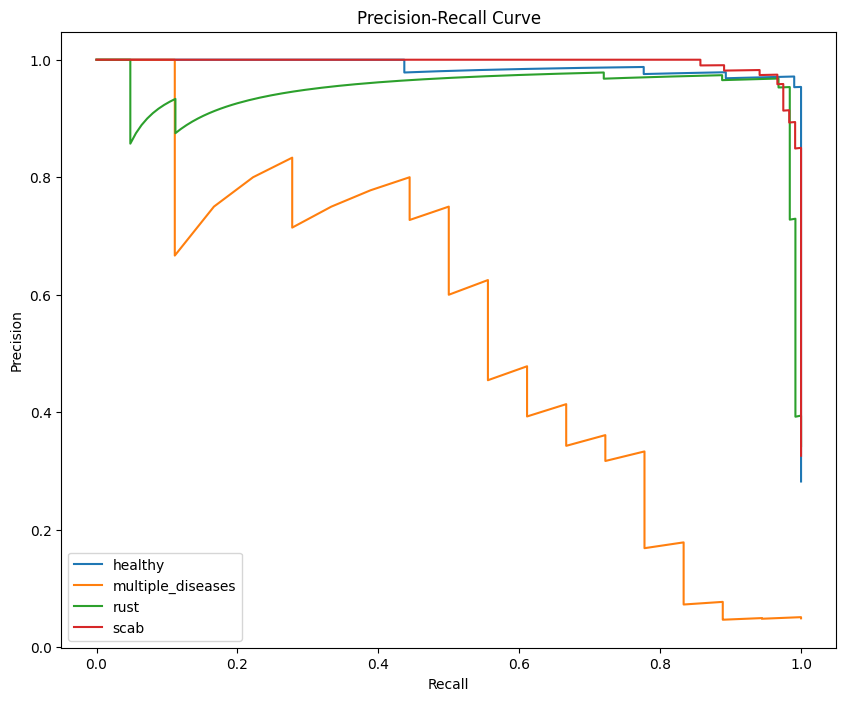

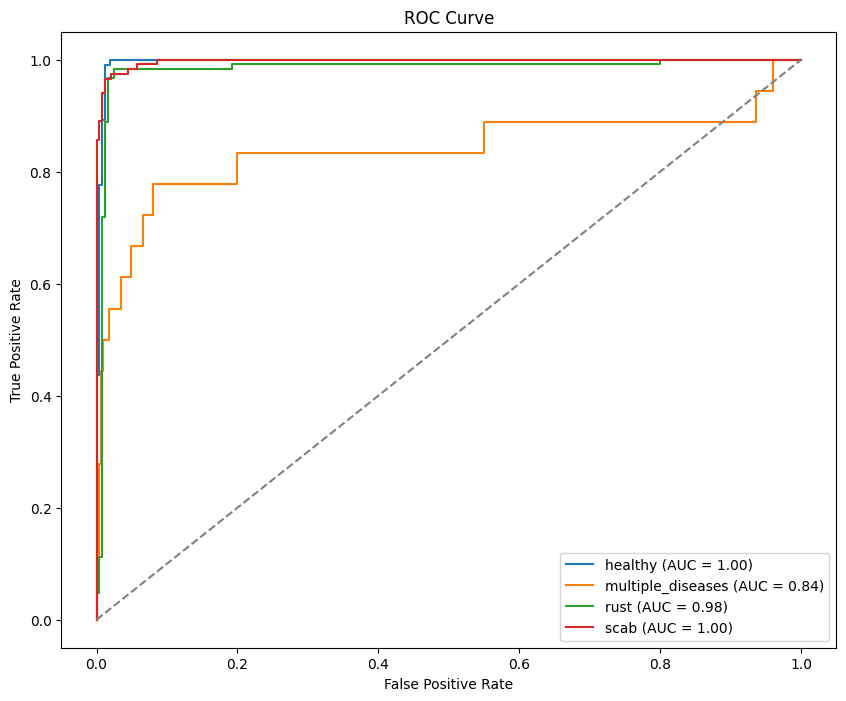


Training fold 2...
Epoch 1/15 - Fold 2
Training Loss: 1.0940, Validation Loss: 0.9687, Validation Accuracy: 0.5941
Epoch 2/15 - Fold 2
Training Loss: 0.9838, Validation Loss: 0.8659, Validation Accuracy: 0.6374
Epoch 3/15 - Fold 2
Training Loss: 0.8531, Validation Loss: 0.7175, Validation Accuracy: 0.7418
Epoch 4/15 - Fold 2
Training Loss: 0.7228, Validation Loss: 0.5784, Validation Accuracy: 0.8496
Epoch 5/15 - Fold 2
Training Loss: 0.6161, Validation Loss: 0.4711, Validation Accuracy: 0.9045
Epoch 6/15 - Fold 2
Training Loss: 0.5297, Validation Loss: 0.4094, Validation Accuracy: 0.9183
Epoch 7/15 - Fold 2
Training Loss: 0.4648, Validation Loss: 0.3685, Validation Accuracy: 0.9396
Epoch 8/15 - Fold 2
Training Loss: 0.4251, Validation Loss: 0.3454, Validation Accuracy: 0.9581
Epoch 9/15 - Fold 2
Training Loss: 0.3875, Validation Loss: 0.3468, Validation Accuracy: 0.9567
Epoch 10/15 - Fold 2
Training Loss: 0.3741, Validation Loss: 0.3493, Validation Accuracy: 0.9567
Epoch 11/15 - Fold 

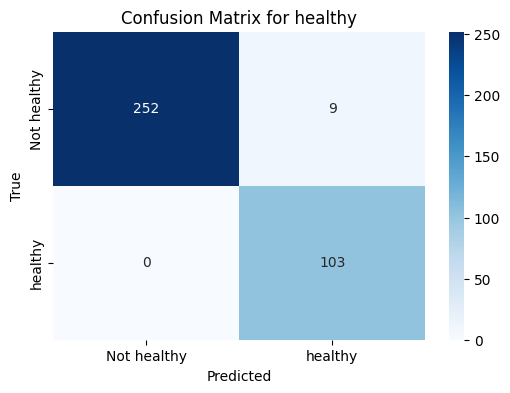


Metrics for class: multiple_diseases
  True Positives (TP): 6
  False Positives (FP): 5
  False Negatives (FN): 12
  True Negatives (TN): 341
  Precision: 0.5455
  Recall: 0.3333
  F1-score: 0.4138


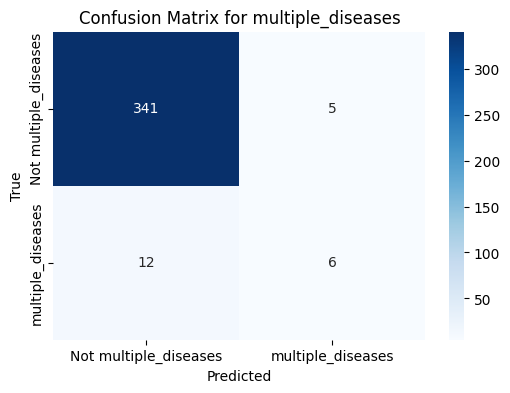


Metrics for class: rust
  True Positives (TP): 123
  False Positives (FP): 3
  False Negatives (FN): 1
  True Negatives (TN): 237
  Precision: 0.9762
  Recall: 0.9919
  F1-score: 0.9840


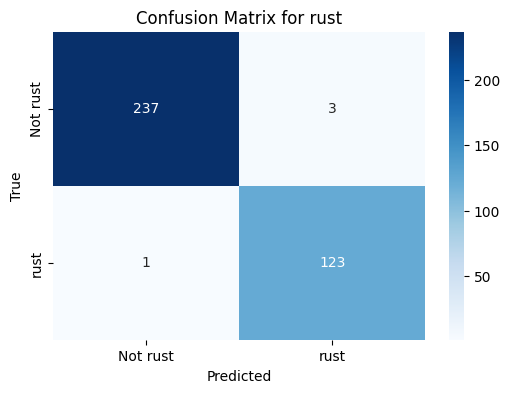


Metrics for class: scab
  True Positives (TP): 116
  False Positives (FP): 16
  False Negatives (FN): 3
  True Negatives (TN): 229
  Precision: 0.8788
  Recall: 0.9748
  F1-score: 0.9243


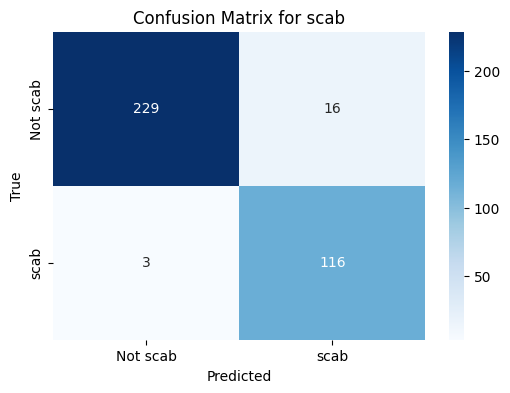

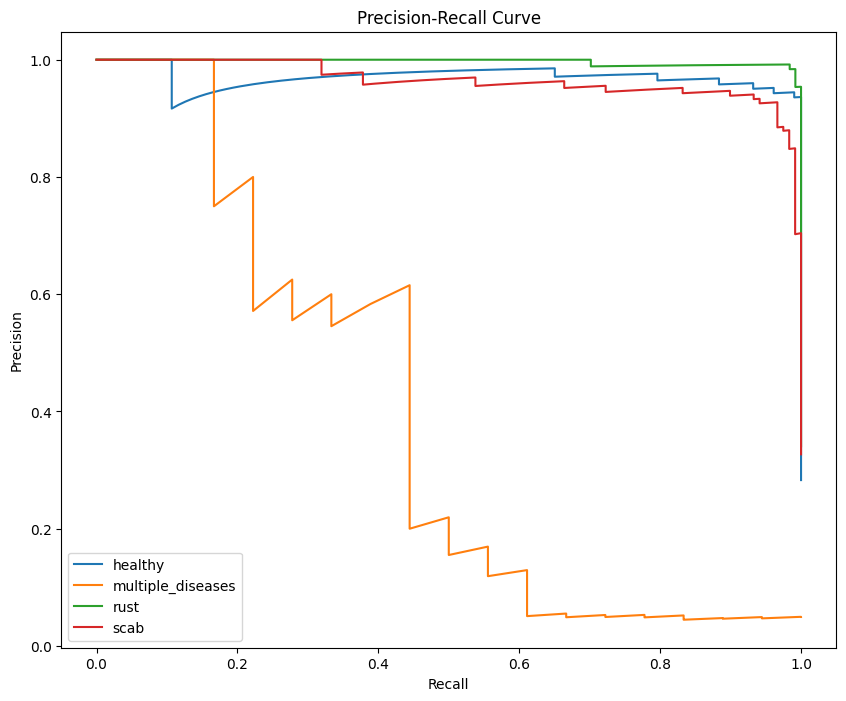

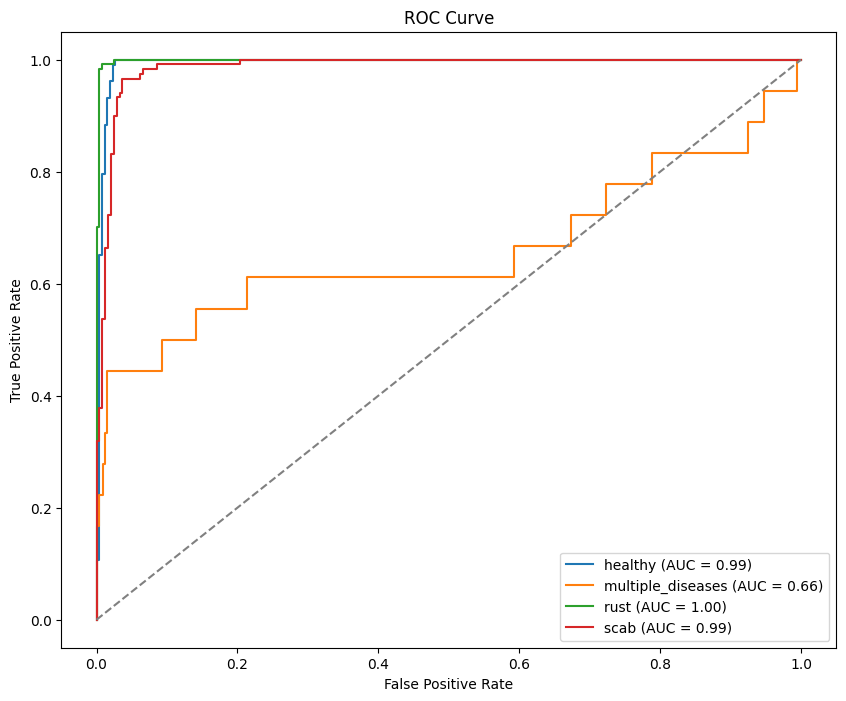


Training fold 3...
Epoch 1/15 - Fold 3
Training Loss: 1.0983, Validation Loss: 0.9759, Validation Accuracy: 0.5659
Epoch 2/15 - Fold 3
Training Loss: 0.9746, Validation Loss: 0.8665, Validation Accuracy: 0.6889
Epoch 3/15 - Fold 3
Training Loss: 0.8550, Validation Loss: 0.7259, Validation Accuracy: 0.7775
Epoch 4/15 - Fold 3
Training Loss: 0.7180, Validation Loss: 0.5900, Validation Accuracy: 0.8530
Epoch 5/15 - Fold 3
Training Loss: 0.6063, Validation Loss: 0.4819, Validation Accuracy: 0.9038
Epoch 6/15 - Fold 3
Training Loss: 0.5240, Validation Loss: 0.4039, Validation Accuracy: 0.9203
Epoch 7/15 - Fold 3
Training Loss: 0.4592, Validation Loss: 0.3591, Validation Accuracy: 0.9299
Epoch 8/15 - Fold 3
Training Loss: 0.4267, Validation Loss: 0.3340, Validation Accuracy: 0.9430
Epoch 9/15 - Fold 3
Training Loss: 0.3978, Validation Loss: 0.3119, Validation Accuracy: 0.9437
Epoch 10/15 - Fold 3
Training Loss: 0.3715, Validation Loss: 0.3071, Validation Accuracy: 0.9560
Epoch 11/15 - Fold 

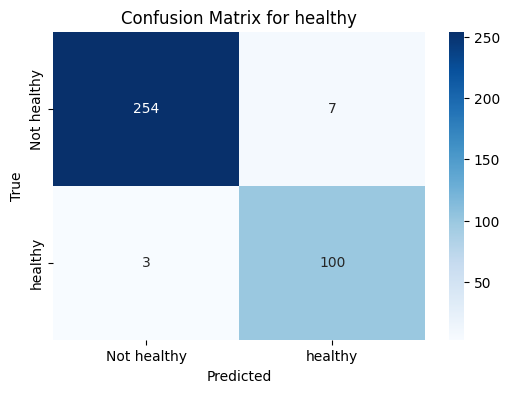


Metrics for class: multiple_diseases
  True Positives (TP): 12
  False Positives (FP): 20
  False Negatives (FN): 7
  True Negatives (TN): 325
  Precision: 0.3750
  Recall: 0.6316
  F1-score: 0.4706


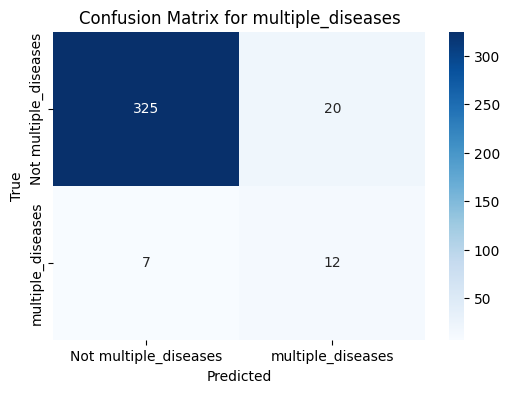


Metrics for class: rust
  True Positives (TP): 124
  False Positives (FP): 6
  False Negatives (FN): 0
  True Negatives (TN): 234
  Precision: 0.9538
  Recall: 1.0000
  F1-score: 0.9764


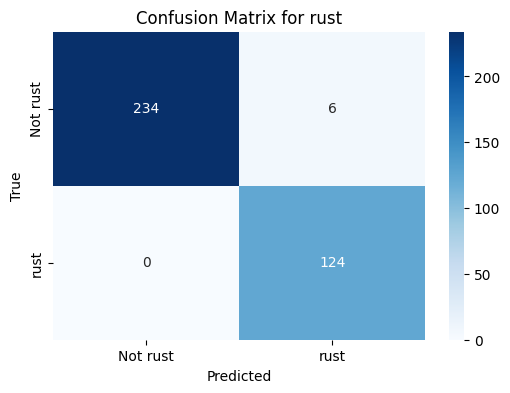


Metrics for class: scab
  True Positives (TP): 114
  False Positives (FP): 10
  False Negatives (FN): 4
  True Negatives (TN): 236
  Precision: 0.9194
  Recall: 0.9661
  F1-score: 0.9421


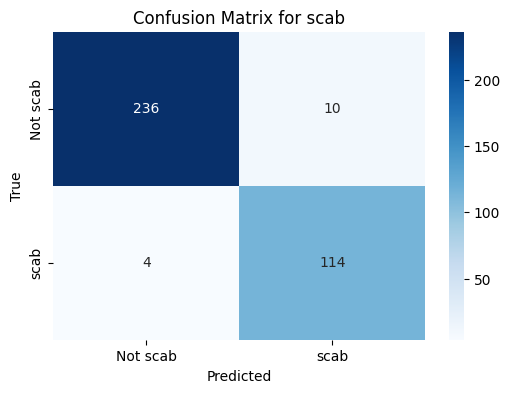

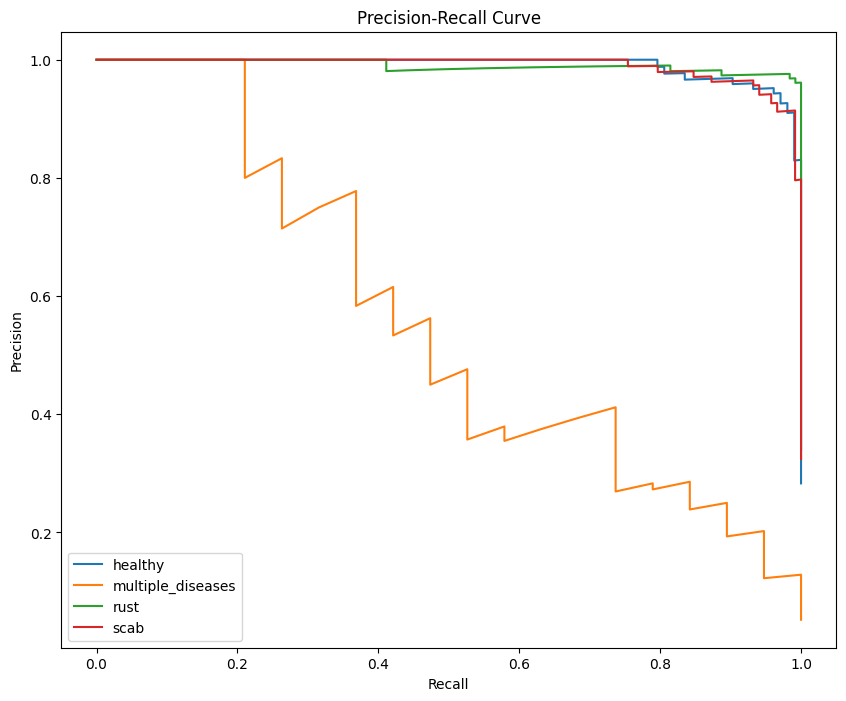

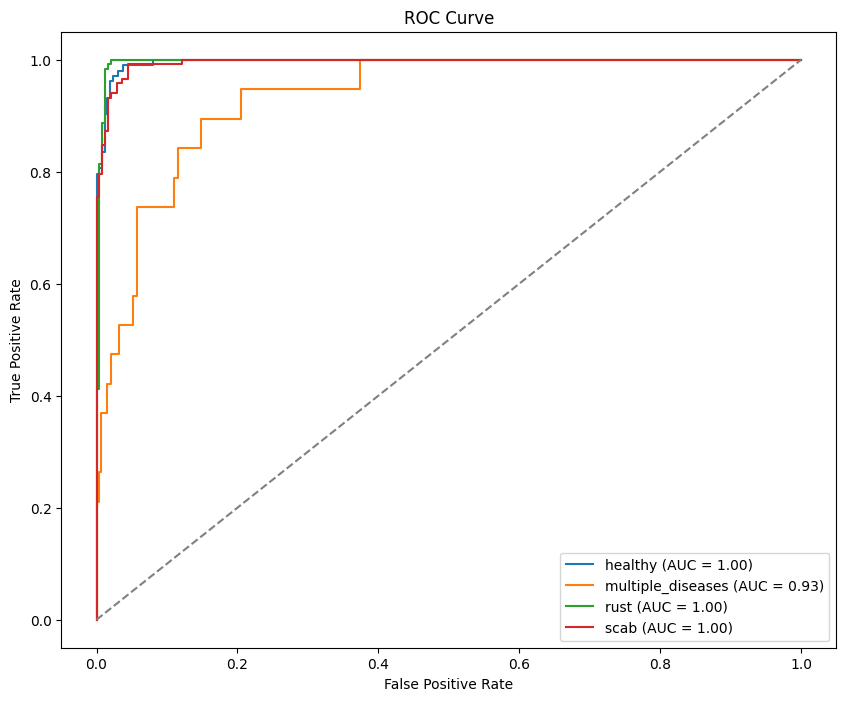


Training fold 4...
Epoch 1/15 - Fold 4
Training Loss: 1.0768, Validation Loss: 0.9693, Validation Accuracy: 0.5130
Epoch 2/15 - Fold 4
Training Loss: 0.9685, Validation Loss: 0.8616, Validation Accuracy: 0.6662
Epoch 3/15 - Fold 4
Training Loss: 0.8527, Validation Loss: 0.7162, Validation Accuracy: 0.7761
Epoch 4/15 - Fold 4
Training Loss: 0.7390, Validation Loss: 0.5815, Validation Accuracy: 0.8386
Epoch 5/15 - Fold 4
Training Loss: 0.6406, Validation Loss: 0.4797, Validation Accuracy: 0.8764
Epoch 6/15 - Fold 4
Training Loss: 0.5529, Validation Loss: 0.4001, Validation Accuracy: 0.9183
Epoch 7/15 - Fold 4
Training Loss: 0.4949, Validation Loss: 0.3295, Validation Accuracy: 0.9430
Epoch 8/15 - Fold 4
Training Loss: 0.4390, Validation Loss: 0.3077, Validation Accuracy: 0.9574
Epoch 9/15 - Fold 4
Training Loss: 0.4098, Validation Loss: 0.2868, Validation Accuracy: 0.9670
Epoch 10/15 - Fold 4
Training Loss: 0.3890, Validation Loss: 0.2903, Validation Accuracy: 0.9615
Epoch 11/15 - Fold 

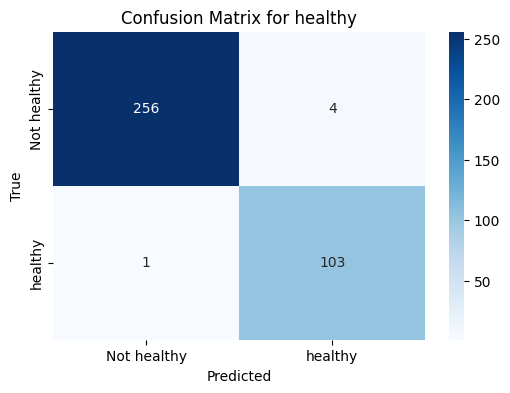


Metrics for class: multiple_diseases
  True Positives (TP): 11
  False Positives (FP): 12
  False Negatives (FN): 7
  True Negatives (TN): 334
  Precision: 0.4783
  Recall: 0.6111
  F1-score: 0.5366


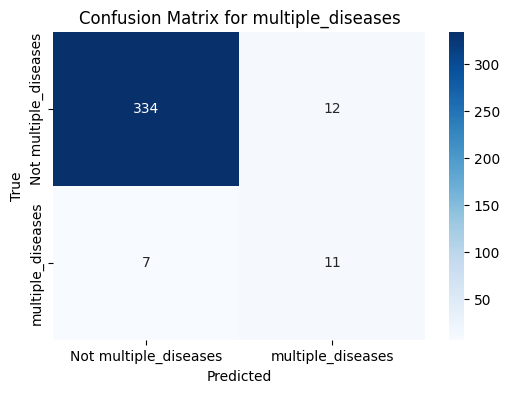


Metrics for class: rust
  True Positives (TP): 123
  False Positives (FP): 7
  False Negatives (FN): 1
  True Negatives (TN): 233
  Precision: 0.9462
  Recall: 0.9919
  F1-score: 0.9685


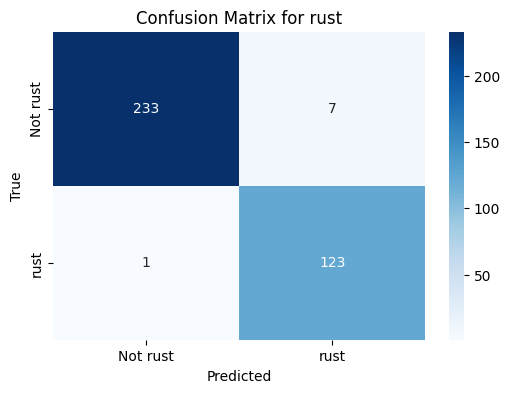


Metrics for class: scab
  True Positives (TP): 114
  False Positives (FP): 5
  False Negatives (FN): 4
  True Negatives (TN): 241
  Precision: 0.9580
  Recall: 0.9661
  F1-score: 0.9620


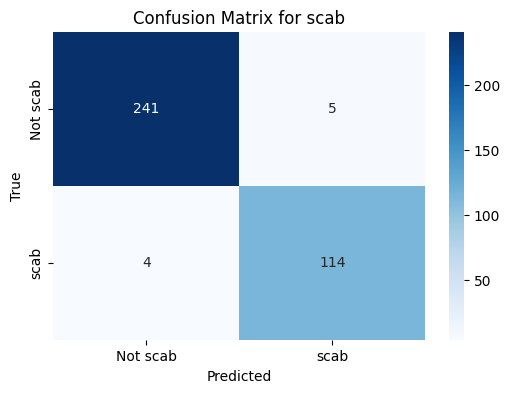

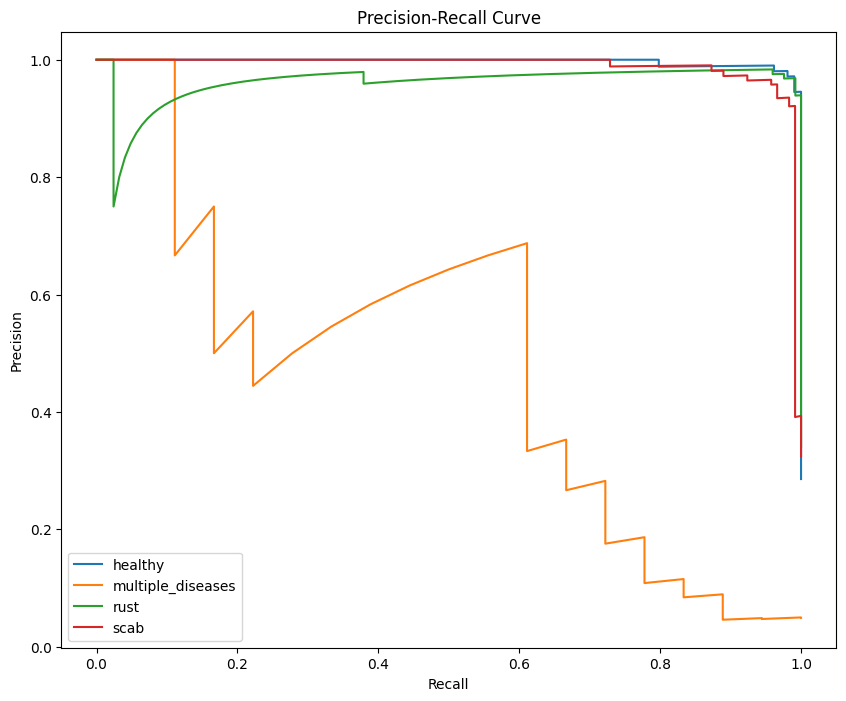

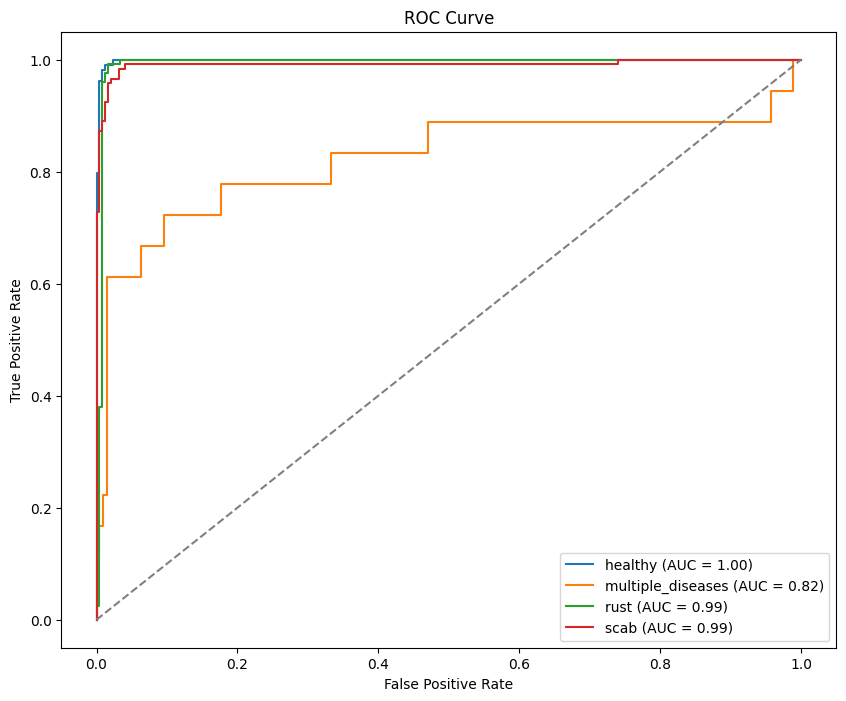


Training fold 5...
Epoch 1/15 - Fold 5
Training Loss: 1.0868, Validation Loss: 0.9573, Validation Accuracy: 0.5968
Epoch 2/15 - Fold 5
Training Loss: 0.9725, Validation Loss: 0.8504, Validation Accuracy: 0.6696
Epoch 3/15 - Fold 5
Training Loss: 0.8432, Validation Loss: 0.7127, Validation Accuracy: 0.7795
Epoch 4/15 - Fold 5
Training Loss: 0.7231, Validation Loss: 0.5767, Validation Accuracy: 0.8510
Epoch 5/15 - Fold 5
Training Loss: 0.6097, Validation Loss: 0.4729, Validation Accuracy: 0.8970
Epoch 6/15 - Fold 5
Training Loss: 0.5271, Validation Loss: 0.4147, Validation Accuracy: 0.9087
Epoch 7/15 - Fold 5
Training Loss: 0.4600, Validation Loss: 0.3446, Validation Accuracy: 0.9423
Epoch 8/15 - Fold 5
Training Loss: 0.4308, Validation Loss: 0.3208, Validation Accuracy: 0.9451
Epoch 9/15 - Fold 5
Training Loss: 0.3990, Validation Loss: 0.3199, Validation Accuracy: 0.9602
Epoch 10/15 - Fold 5
Training Loss: 0.3790, Validation Loss: 0.2862, Validation Accuracy: 0.9609
Epoch 11/15 - Fold 

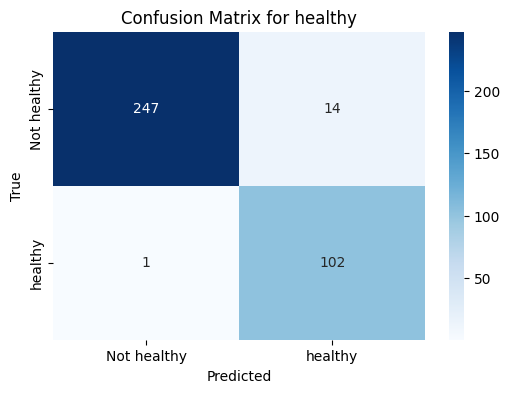


Metrics for class: multiple_diseases
  True Positives (TP): 8
  False Positives (FP): 7
  False Negatives (FN): 10
  True Negatives (TN): 339
  Precision: 0.5333
  Recall: 0.4444
  F1-score: 0.4848


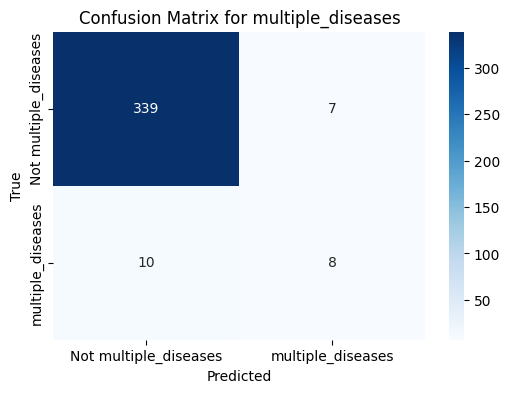


Metrics for class: rust
  True Positives (TP): 124
  False Positives (FP): 8
  False Negatives (FN): 1
  True Negatives (TN): 231
  Precision: 0.9394
  Recall: 0.9920
  F1-score: 0.9650


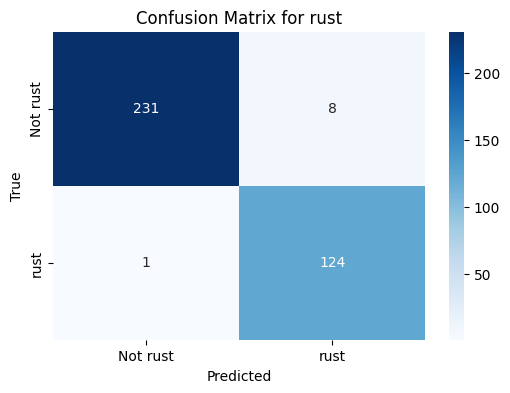


Metrics for class: scab
  True Positives (TP): 111
  False Positives (FP): 4
  False Negatives (FN): 7
  True Negatives (TN): 242
  Precision: 0.9652
  Recall: 0.9407
  F1-score: 0.9528


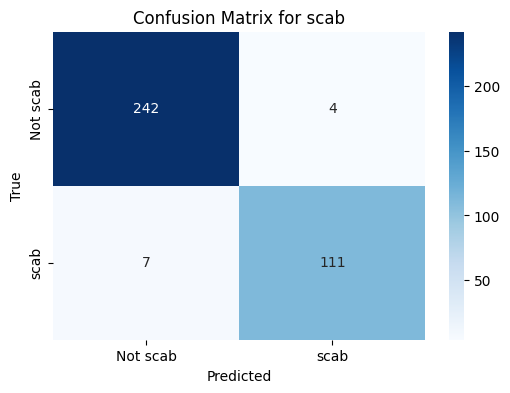

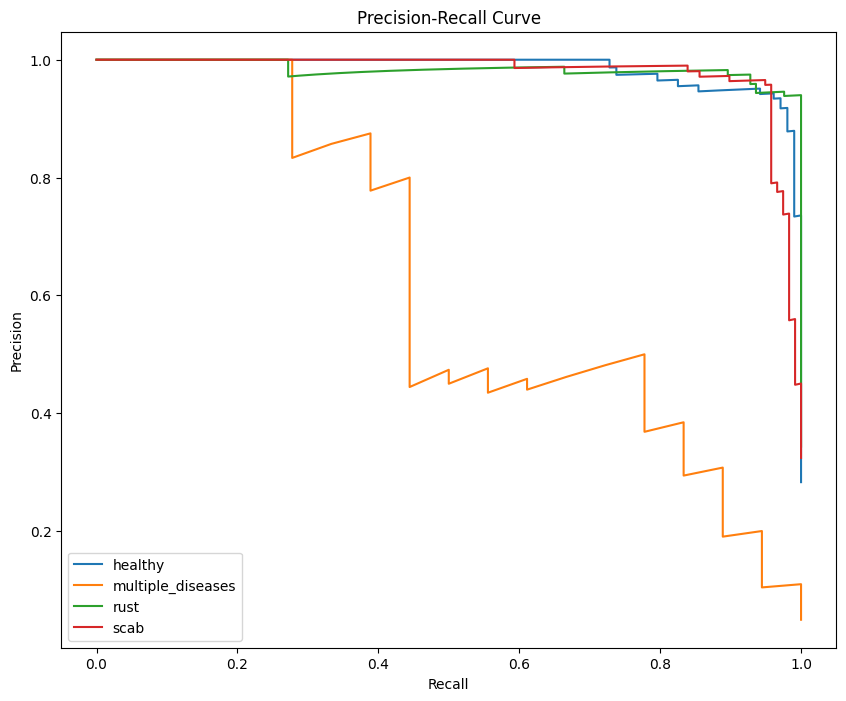

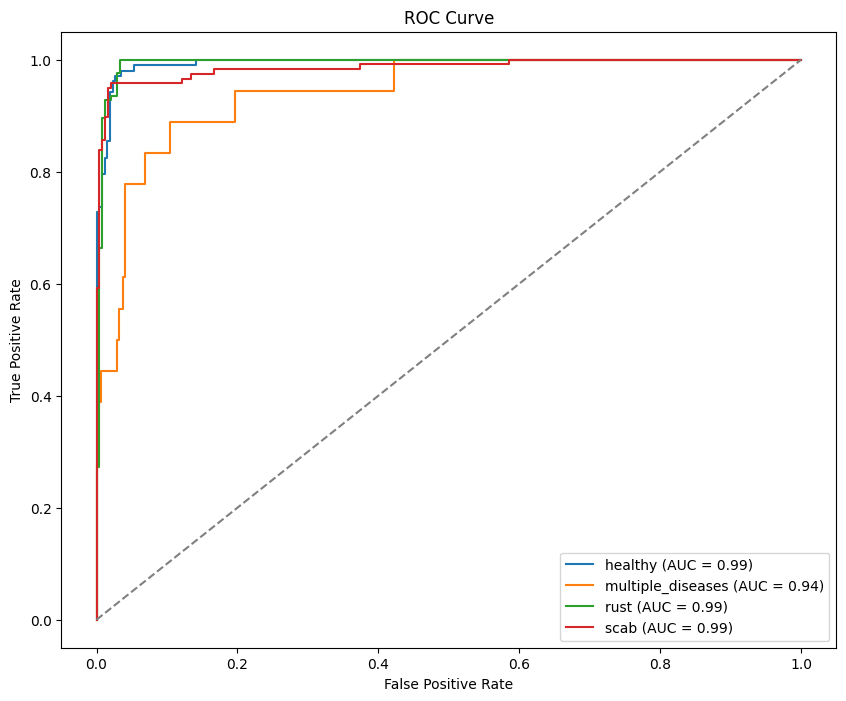

Kaggle submission file 'submission.csv' generated successfully!
  image_id   healthy  multiple_diseases      rust      scab
0   Test_0  0.041867           0.329303  0.982682  0.026757
1   Test_1  0.044403           0.275595  0.988551  0.039510
2   Test_2  0.029870           0.238202  0.027867  0.994421
3   Test_3  0.989447           0.287039  0.043405  0.045419
4   Test_4  0.049007           0.329598  0.985022  0.033798


In [ ]:
from sklearn.model_selection import StratifiedKFold
from torchvision import models, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn import BCEWithLogitsLoss
from copy import deepcopy

# Data augmentation for better generalization
# V8->V9 lessened the strength of augmentation
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Apply validation transforms to test dataset
test_data.transform = val_transform

# Create test DataLoader
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Model initialization
# Upgraded to resnet34 from resnet18 because was hitting limits of model capacity
def initialize_model():
    model = models.resnet34()
    # Construct the full path to the .pth file inside the downloaded directory
    weights_file_path = os.path.join(rnapark_resnet34_b627a593_pth_path, 'resnet34-b627a593.pth')
    state_dict = torch.load(weights_file_path, map_location="cpu")
    model.load_state_dict(state_dict)
    # Added dropout layer
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(model.fc.in_features, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(512, 4)  # Output layer
    )
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare labels and class weights
y_single = [np.argmax(sample[1]) for sample in train_data]  # For stratification
all_labels = torch.stack([torch.tensor(sample[1], dtype=torch.float32) for sample in train_data])
pos = all_labels.sum(dim=0)
neg = all_labels.shape[0] - pos
pos_weight = (neg / (pos + 1e-5)).to(device)

# K-Fold setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Variables to track training and predictions
all_train_losses = []
all_val_accuracies = []
fold_accuracies = []
fold_test_predictions = []  # <- Store test predictions per fold

# K-Fold training loop
for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, y_single)):
    print(f"\nTraining fold {fold + 1}...")

    # Deepcopy datasets to avoid transform overwrite
    train_dataset = deepcopy(train_data)
    val_dataset   = deepcopy(train_data)
    train_dataset.transform = train_transform
    val_dataset.transform   = val_transform

    # Build DataLoaders for this fold
    train_loader_fold = torch.utils.data.DataLoader(torch.utils.data.Subset(train_dataset, train_idx),
                                                    batch_size=64, shuffle=True)
    val_loader_fold = torch.utils.data.DataLoader(torch.utils.data.Subset(val_dataset, val_idx),
                                                  batch_size=64, shuffle=False)

    # Initialize model, optimizer, scheduler
    model = initialize_model().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-6)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=2e-4,
        epochs=15,
        steps_per_epoch=len(train_loader_fold),
        pct_start=0.2,
        div_factor=10,
        final_div_factor=100
    )
    loss_fn = BCEWithLogitsLoss(pos_weight=pos_weight, reduction="mean")
    patience = 5

    best_val_loss = float('inf')
    best_val_accuracy = 0
    epochs_without_improvement = 0

    train_losses = []
    val_losses = []
    val_accuracies = []

    # 15 epochs training
    for epoch in range(15):
        print(f"Epoch {epoch+1}/15 - Fold {fold+1}")
        train_loss = train_loop(train_loader_fold, model, loss_fn, optimizer, device, smoothing=0.02)
        val_loss, val_accuracy = evaluate_model(val_loader_fold, model, loss_fn, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        scheduler.step()

    fold_accuracies.append(best_val_accuracy)
    all_train_losses.extend(train_losses)
    all_val_accuracies.extend(val_accuracies)

    # Separate thresholds for each class (adjust thresholds as needed)
    # Updated thresholds, prioritize improving F1 score
    #thresholds = [0.6, 0.7, 0.4, 0.5]
    # thresholds = [0.6, 0.65, 0.4, 0.45]
    # thresholds = [0.5, 0.55, 0.45, 0.45]
    thresholds = [0.5, 0.6, 0.4, 0.45] # 1, 3, 4 are fixed now, 0.6 better than 0.55, 0.65

    # Get predictions and probabilities from the validation set
    y_true, y_probs = predict_loop(val_loader_fold, model, device)

    # Apply the thresholds: convert probabilities to binary predictions per class
    y_pred = (y_probs >= torch.tensor(thresholds).to(y_probs.device))  # Compare each class prob with its threshold
    y_pred = y_pred.int().numpy()  # Convert boolean to int (0 or 1)

    # Plot confusion matrix and other metrics
    plot_confusion_matrix(y_true.numpy(), y_pred, ['healthy','multiple_diseases','rust','scab'])
    plot_precision_recall_curve(y_true.numpy(), y_probs.numpy(), ['healthy','multiple_diseases','rust','scab'])
    plot_roc_curve(y_true.numpy(), y_probs.numpy(), ['healthy','multiple_diseases','rust','scab'])

    # Generate predictions on the test set for this fold using predict_test_loop
    fold_pred = predict_test_loop(test_loader, model, device)

    # Store the raw probabilities for later averaging
    fold_test_predictions.append(fold_pred)

# After all folds: average predictions
avg_test_predictions = torch.stack(fold_test_predictions).mean(dim=0).cpu()
predictions_np = avg_test_predictions.numpy()
# Build submission DataFrame
submission_columns = ['healthy', 'multiple_diseases', 'rust', 'scab']
submission_df = pd.DataFrame(predictions_np, columns=submission_columns)
submission_df.insert(0, 'image_id', test_data.data['image_id'].tolist())

submission_file_path = 'submission.csv'
submission_df.to_csv(submission_file_path, index=False)
print(f"Kaggle submission file '{submission_file_path}' generated successfully!")
print(submission_df.head())

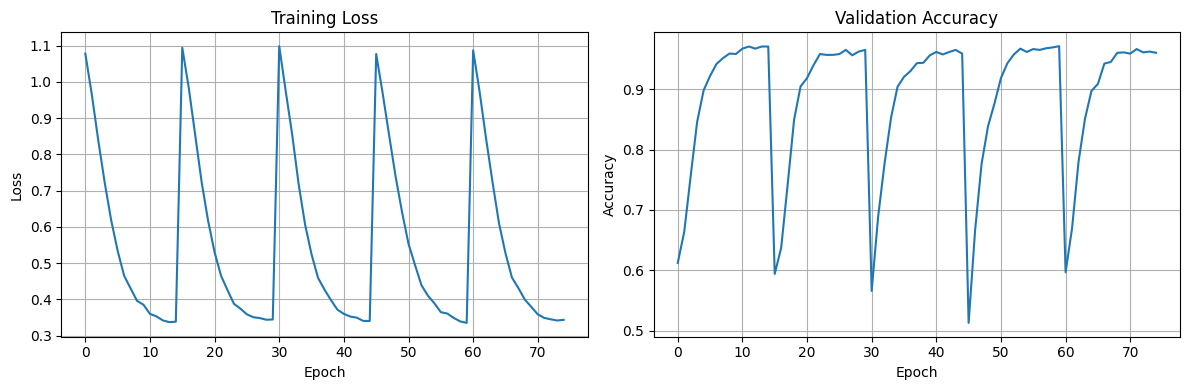


Average Validation Accuracy across all folds: 0.9607


In [ ]:
# Plot training curves and report accuracy
plot_training_curves(all_train_losses, all_val_accuracies)
mean_val_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"\nAverage Validation Accuracy across all folds: {mean_val_accuracy:.4f}")

## Summary/Interpretation of metrics:

### Model w/o MixUp Summary
| Metric                    | Value   |
|---------------------------|---------|
| Avg Val Loss               | 0.318   |
| Avg Val Accuracy           | 0.965   |
| F1 — Healthy               | 0.959   |
| F1 — Multiple Diseases     | 0.495   |
| F1 — Rust                  | 0.969   |
| F1 — Scab                  | 0.948   |
| Macro F1 Average           | 0.843   |

### Comparison
| Metric                       | No Mixup | Mixup | Change       |
|------------------------------|----------|-------|--------------|
| Val Loss                      | 0.2995   | 0.432 | Worse        |
| Val Accuracy                  | 0.966    | 0.913 | ↓ 5.3%       |
| Healthy F1                    | 0.959    | 0.936 | ↓            |
| Multiple Diseases F1          | 0.495    | 0.444 | ↓            |
| Rust F1                       | 0.969    | 0.965 | Slight ↓     |
| Scab F1                       | 0.948    | 0.951 | Slight ↑     |


It looked like MixUp actually hurt the performance of my model, so I removed it and submitted again on Kaggle, but the overall Kaggle score with MixUp = True performed better.